In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import os
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_model = True #@param {type: "boolean"}

In [ ]:
# Dataset specific parameters
folder_path = "/content/drive/MyDrive/eCAADe2025 Workshop"#@param {type: "string"}

dataset_folder = folder_path + "/datasets/voxels_dataset"

except_data_shape = (24,24,24)  #@param

save_model = True

model_save_path = folder_path + "/_models"
# create save_model_location if it doens not exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

save_model_name = "Voxel_24_24_24" #@param {type: "string"}
model_name = save_model_name

save_geo_path = folder_path + "/_geometries/voxel"
if not os.path.exists(save_geo_path):
    os.makedirs(save_geo_path)
save_geo_name = "Voxel_Polysurface" #@param {type: "string"}
geo_export_name = save_geo_name

In [ ]:
# hyperparameters
latent_dim = 128 #@param {type: "number"}
batch_size = 32 #@param {type: "number"}
epochs = 100 #@param {type: "number"}
train_test_split = 0.90 #@param {type: "number"}
r_loss_factor = 0.1 #@param {type: "number"}

hidden_dims = [64, 128, 256] #@param
learning_rate = 0.0003 #@param {type: "number"}
#loss_type = "MSE" #@param ["MSE", "MAE"] {allow-input: true}
optimizer_type = "Adam" #@param ["Adam", "SGD"]
activation = 'relu'#@param ["relu", "leaky_relu"] {allow-input: true}
use_batch_norm = True #@param {type: "boolean"}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("sellected device", device)
if str(device) == 'cuda':
    print("CUDA is available")
else:
    print("CUDA is not available - choose a GPU Hardware to speed up AI training")

sellected device cuda
CUDA is available


In [ ]:
class VoxelDataset(Dataset):
    def __init__(self, folder_path, expected_shape=(24,24,24)):
        self.folder_path = folder_path
        self.expected_shape = expected_shape
        self.file_paths = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.npy'):
                    file_path = os.path.join(root, file)
                    item = np.load(file_path)
                    #print(f"Loaded file {file} with shape {item.shape}")
                    if item.shape == expected_shape:
                        self.file_paths.append(file_path)
                    else:
                        print(f"Skipping file {file} due to unexpected shape: {item.shape}")


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        item = np.load(file_path)
        return torch.tensor(item, dtype=torch.float32)

In [ ]:
def visualize_voxel_grid(voxel_grid, color='b'):
    # Check if voxel_grid is a PyTorch tensor
    if isinstance(voxel_grid, torch.Tensor):
        voxel_grid = voxel_grid.cpu().detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure voxel_grid is a boolean array
    voxel_grid = voxel_grid.astype(bool)

    # Create a color array with the same shape as voxel_grid
    colors = np.empty(voxel_grid.shape, dtype=object)
    colors[voxel_grid] = color
    colors[~voxel_grid] = 'none'  # Set non-voxel colors to 'none'

    # Plot the voxels
    ax.voxels(voxel_grid, facecolors=colors, edgecolor='k')

    plt.show()


In [ ]:
def plot_tensor_as_bar_graph(tensor, num_bins=10):
    # Flatten the tensor

    # check if tensor is a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().detach().numpy()

    numpy_array = tensor.flatten()

    # Plot the numerical values as a bar graph with 10 bins
    plt.figure(figsize=(8, 3))
    plt.hist(numpy_array, bins=num_bins)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Tensor Values')
    plt.show()

# Example usage
#example_tensor = torch.rand(24, 24, 24)
#plot_tensor_as_bar_graph(example_tensor)

Shape of Data torch.Size([32, 24, 24, 24])
Data type:  torch.float32
Number of batches in Training Set:  42


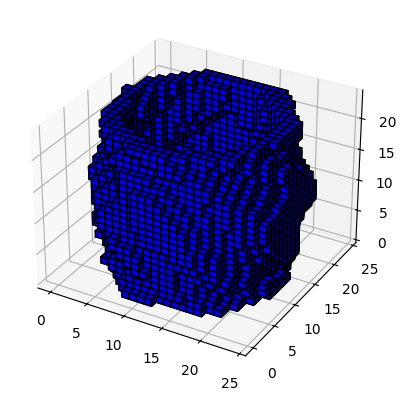

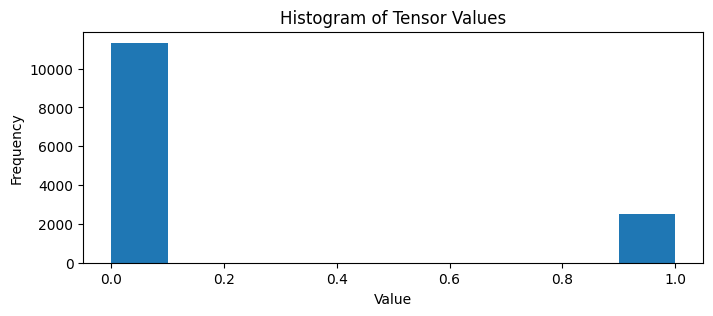

Number of batches in Test Set:  5


In [ ]:
dataset = VoxelDataset(dataset_folder, except_data_shape)

# Split the dataset into training and test sets
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_data in train_dataloader:
    print("Shape of Data",batch_data.shape)  # Should print torch.Size([batch_size, 3, 1500])
    print("Data type: ", batch_data.dtype)  # Should print torch.float32
    print("Number of batches in Training Set: ", len(train_dataloader))
    visualize_voxel_grid(batch_data[0])
    plot_tensor_as_bar_graph(batch_data[0])
    break

for batch_data in test_dataloader:
    print("Number of batches in Test Set: ", len(test_dataloader))
    break

In [ ]:
class VAE_Voxel(nn.Module):
    def __init__(self, input_channels=1, hidden_dims=[32,65,128], latent_dim=128, tensor_shape=(24, 24, 24), activation='relu', use_batch_norm=True):
        super(VAE_Voxel, self).__init__()

        if hidden_dims is None:
            raise ValueError("Please provide a list of hidden dimensions for the encoder.")
        self.hidden_dims = hidden_dims

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()

        self.encoder_spatial_shape = None  # Store only the spatial shape
        self.use_batch_norm = use_batch_norm

        # Build Encoder
        encoder_layers = []
        in_channels = input_channels
        for h_dim in self.hidden_dims:
            encoder_layers.append(nn.Conv3d(in_channels, h_dim, kernel_size=4, stride=2, padding=1))
            if self.use_batch_norm and h_dim != self.hidden_dims[-1]:
                encoder_layers.append(nn.BatchNorm3d(h_dim))
            encoder_layers.append(self.activation)
            in_channels = h_dim
        self.encoder = nn.Sequential(*encoder_layers)

        # Compute the size of the flattened feature map after the encoder
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, *tensor_shape)
            dummy_output = self.encoder(dummy_input)
            self.encoder_spatial_shape = dummy_output.shape[2:] # Store only spatial dimensions
            flattened_size = dummy_output.view(1, -1).size(1)

        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_var = nn.Linear(flattened_size, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, flattened_size)

        # Build Decoder
        decoder_layers = []
        hidden_dims_copy = self.hidden_dims.copy()
        hidden_dims_copy.reverse()
        for i in range(len(hidden_dims_copy) - 1):
            decoder_layers.append(nn.ConvTranspose3d(hidden_dims_copy[i], hidden_dims_copy[i + 1], kernel_size=4, stride=2, padding=1))
            if self.use_batch_norm:
                decoder_layers.append(nn.BatchNorm3d(hidden_dims_copy[i + 1]))
            decoder_layers.append(self.activation)
        decoder_layers.append(nn.ConvTranspose3d(hidden_dims_copy[-1], input_channels, kernel_size=4, stride=2, padding=1))
        decoder_layers.append(nn.Sigmoid())  # Use Sigmoid activation function for output
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        self.original_shape = x.shape  # Store the original shape
        x = self.encoder(x)
        self.encoder_spatial_shape = x.shape[2:] # Store only spatial dimensions
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        #print("z input shape", z.shape)
        x = self.decoder_input(z)
        # Reshape using the current batch size and stored spatial shape
        x = x.view(z.size(0), self.hidden_dims[-1], *self.encoder_spatial_shape)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

In [ ]:
# Example usage

input_channels = 1
tensor_shape = except_data_shape
data = torch.randn(batch_size, input_channels, *tensor_shape)

# Initialize the model with batch normalization

test_model = VAE_Voxel(input_channels=input_channels, hidden_dims=hidden_dims, latent_dim=latent_dim, tensor_shape=tensor_shape, activation=activation, use_batch_norm=True)

# Forward pass
reconstructed, mu, log_var = test_model(data)
print("Input shape:", data.shape)
print("Reconstructed shape:", reconstructed.shape)
print("Mu shape:", mu.shape)
print("Log var shape:", log_var.shape)

Input shape: torch.Size([32, 1, 24, 24, 24])
Reconstructed shape: torch.Size([32, 1, 24, 24, 24])
Mu shape: torch.Size([32, 128])
Log var shape: torch.Size([32, 128])


In [ ]:
def calc_loss(recon_x, x, mu, log_var):
    # Ensure recon_x and x have the same shape
    assert recon_x.shape == x.shape, "Shape mismatch between recon_x and x"

    # Binary Cross Entropy loss
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Kullback-Leibler Divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    loss = r_loss_factor * bce_loss + kl_divergence


    return loss

# test the loss function

# make sure recon_x and x have the same shape and are between 0 and 1
test_recon_x = torch.rand(1, 32, 24, 24, 24)
test_x = torch.rand(1, 32, 24, 24, 24)

test_mu = torch.randn(32, 256)
test_log_var = torch.randn(32, 256)
loss = calc_loss(test_recon_x, test_x, test_mu, test_log_var)
print(loss)


tensor(50779.8438)


In [ ]:
def evaluate_model(model, test_dataloader, device=device):
    model.eval()
    reconstruction_loss = 0
    total_samples = 0

    with torch.no_grad():
        for batch_data in test_dataloader:
            batch_data = batch_data.to(device)
            batch_data = batch_data.unsqueeze(1)
            recon_batch, _, _ = model(batch_data)

            # Calculate the reconstruction loss for the batch
            batch_data_np = batch_data.cpu().detach().numpy()
            recon_batch_np = recon_batch.cpu().detach().numpy()
            batch_loss = np.sum((batch_data_np - recon_batch_np) ** 2)
            reconstruction_loss += batch_loss
            total_samples += batch_data.size(0)

    reconstruction_loss /= total_samples
    print(f'Reconstruction Loss: {reconstruction_loss}')
    return reconstruction_loss

In [ ]:
print("Training model with following hyperparameters: \nhidden_dims: ", hidden_dims, "\nlatent_dim: ", latent_dim,
                "\noptimizer_type: ", optimizer_type,  "\nlearning_rate: ", learning_rate, "\nactivation: ", activation, "\nUsing Batch Normalization:",use_batch_norm)

model = VAE_Voxel(input_channels=input_channels,
      hidden_dims=hidden_dims,
      latent_dim=latent_dim,
      tensor_shape=tensor_shape,
      activation=activation,
      use_batch_norm=use_batch_norm
      ).to(device)

#print(model)
print("Model initialized with device: ", device)
# print number of parameters
num_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: ', num_params)
print("Anticipated input shape: ", tensor_shape)

print("Number of Model Parameters: ", num_params)
print("Number of model layers: ", len(list(model.parameters())))



Training model with following hyperparameters: 
hidden_dims:  [64, 128, 256] 
latent_dim:  128 
optimizer_type:  Adam 
learning_rate:  0.0003 
activation:  relu 
Using Batch Normalization: True
Model initialized with device:  cuda
Number of parameters:  7913857
Anticipated input shape:  (24, 24, 24)
Number of Model Parameters:  7913857
Number of model layers:  26


In [ ]:
if optimizer_type == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
else:
    raise ValueError("Optimizer must be Adam or SGD")

In [ ]:
    losses = []
    eval_losses = []
    for epoch in range(epochs):
        train_loss = 0
        model.train() # Set model to training mode
        for batch_data in train_dataloader:
            batch_data = batch_data.to(device)
            batch_data = batch_data.unsqueeze(1)

            optimizer.zero_grad()
            recon_batch, mu, log_var = model(batch_data)

            loss = calc_loss(recon_batch, batch_data, mu, log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Evaluate the model after each epoch
        model.eval() # Set model to evaluation mode
        eval_loss = 0
        for batch_data in test_dataloader:
            batch_data = batch_data.to(device)
            batch_data = batch_data.unsqueeze(1)

            recon_batch, mu, log_var = model(batch_data)
            eval_loss += calc_loss(recon_batch, batch_data, mu, log_var).item()

        eval_losses.append(eval_loss / len(test_dataloader.dataset))
        losses.append(train_loss / len(train_dataloader.dataset))
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_dataloader.dataset)}, Eval Loss: {eval_loss / len(test_dataloader.dataset)}')



Epoch 1, Train Loss: 683.1382659029562, Eval Loss: 529.2987344820206
Epoch 2, Train Loss: 462.2373990736777, Eval Loss: 423.7238167540668
Epoch 3, Train Loss: 399.6992929304753, Eval Loss: 379.0334907427226
Epoch 4, Train Loss: 371.4227307927844, Eval Loss: 358.65967800192635
Epoch 5, Train Loss: 355.3277358892664, Eval Loss: 344.8490709278681
Epoch 6, Train Loss: 337.31593747770404, Eval Loss: 326.557697452911
Epoch 7, Train Loss: 323.37051921130313, Eval Loss: 322.81224917059075
Epoch 8, Train Loss: 312.36249503915167, Eval Loss: 304.9856458690069
Epoch 9, Train Loss: 301.4066667484185, Eval Loss: 297.4029156410531
Epoch 10, Train Loss: 292.9154688168878, Eval Loss: 294.2395320526541
Epoch 11, Train Loss: 286.7780327876772, Eval Loss: 282.06852993899827
Epoch 12, Train Loss: 277.6738235264608, Eval Loss: 277.44911507384415
Epoch 13, Train Loss: 270.8581868582483, Eval Loss: 269.9020561322774
Epoch 14, Train Loss: 265.1540037761903, Eval Loss: 268.7761263912671
Epoch 15, Train Loss: 2

In [ ]:
# save the model
if save_model == True:
  torch.save(model, os.path.join(model_save_path, model_name))
  print("Model saved to: ", os.path.join(model_save_path, model_name))


Model saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_models/Voxel_24_24_24


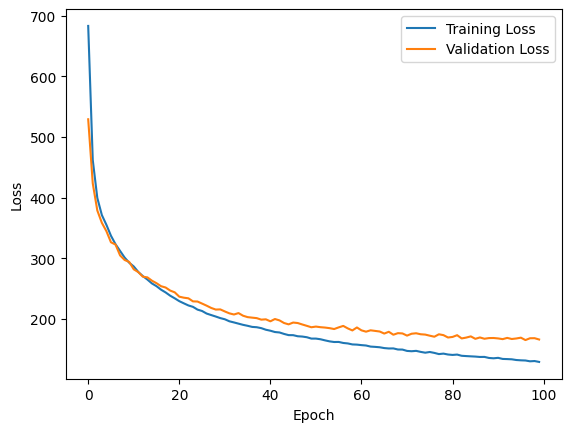

In [ ]:
# plot the training losses and val losses
plt.plot(losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
if train_model == True:
    # Assuming best_model and test_dataloader are already defined
    model.eval()

    for batch_data in test_dataloader:
        print("Number of batches in Test Set: ", len(test_dataloader))
        test_data = batch_data.clone().detach().to(device)
        break


    #test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
    test_data = test_data.unsqueeze(1)
    recon_data, _, _ = model(test_data)

    # calculate the reconstruction accuracy accros the entire test data
    test_data = test_data.cpu().detach().numpy()
    recon_data = recon_data.cpu().detach().numpy()

    reconstruction_loss = np.sum((test_data - recon_data) ** 2)
    print(f'Reconstruction Loss of Batch: {reconstruction_loss}')

    recon_data_rounded = np.round(recon_data)

Number of batches in Test Set:  5
Reconstruction Loss of Batch: 12928.1259765625


Orinial Voxel Model


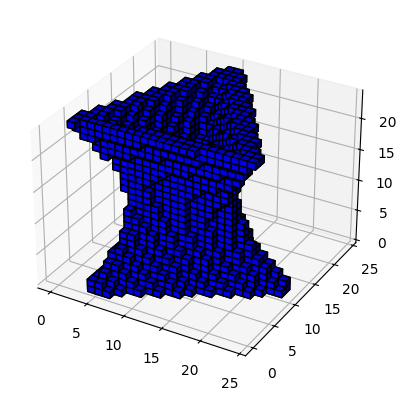

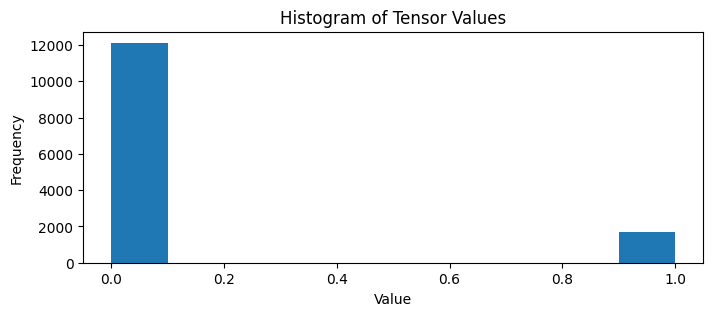

Reconstructed Voxel Model


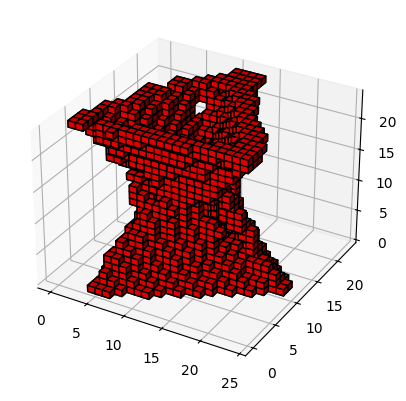

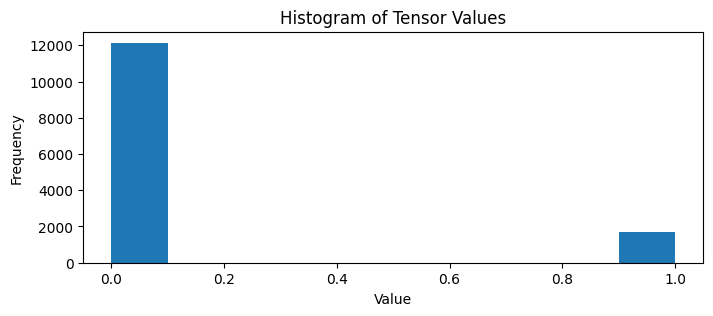

In [ ]:
if train_model == True:
    random_index = random.randint(0, batch_size-1)
    print("Orinial Voxel Model")
    #reverse the squeeze on the test data
    test_data_for_viz = np.squeeze(test_data, axis=1)
    visualize_voxel_grid(test_data_for_viz [random_index])
    plot_tensor_as_bar_graph(test_data_for_viz[random_index])


    print("Reconstructed Voxel Model")
    recon_data_for_viz = np.squeeze(recon_data_rounded, axis=1)

    visualize_voxel_grid(recon_data_for_viz[random_index], color='r')
    plot_tensor_as_bar_graph(recon_data_for_viz[random_index])

In [ ]:
# load trained model
loaded_model = torch.load(os.path.join(model_save_path, model_name), weights_only=False)
print("Loaded model from: ", os.path.join(model_save_path, model_name))
loaded_model.eval()

Loaded model from:  /content/drive/MyDrive/eCAADe2025 Workshop/_models/Voxel_24_24_24


VAE_Voxel(
  (activation): ReLU()
  (encoder): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=6912, out_features=128, bias=True)
  (fc_var): Linear(in_features=6912, out_features=128, bias=True)
  (decoder_input): Linear(in_features=128, out_features=6912, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose3d(1

Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_0.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_1.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_2.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_3.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_4.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_5.npy
Shape of new voxel: (24, 24, 24)
Generated voxel saved to:  /content/drive/MyDrive/eCAADe2025 Workshop/_geometries/Voxel_Polysurface_6.npy
Shape of new voxel: (24, 24

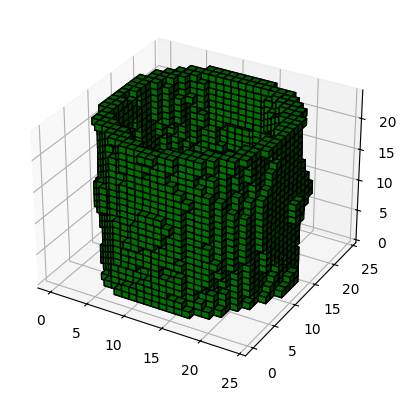

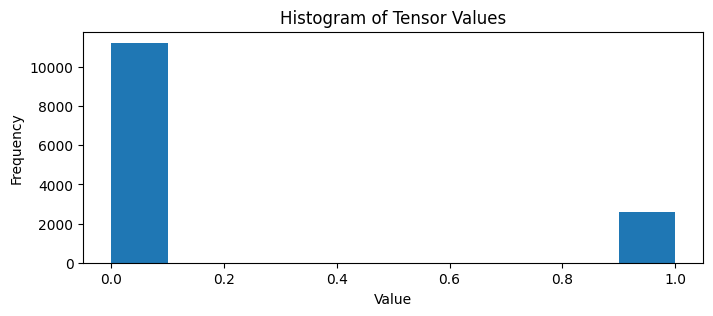

In [ ]:
#@title Generate new geometries
num_generated_geometries = 10 #@param {type: "number"}

# Set the model to evaluation mode
loaded_model.eval()

generated_voxels = []


with torch.no_grad():
    for i in range(num_generated_geometries):
        # Generate random latent vectors
        # The shape of the latent vector should match the latent_dim of the model
        z = torch.randn(1, latent_dim).to(device)

        # Decode the latent vector to generate a new voxel
        new_voxel = loaded_model.decode(z)

        # Process the generated voxel (e.g., round to binary)
        new_voxel_rounded = torch.round(new_voxel)

        # Remove the batch and channel dimensions and convert to numpy
        new_voxel_np = new_voxel_rounded.squeeze().cpu().numpy()
        print("Shape of new voxel:", new_voxel_np.shape)

        #save generated voxels
        generated_voxel_save_path = os.path.join(save_geo_path, save_geo_name+'_'+str(i)+".npy")
        np.save(generated_voxel_save_path, new_voxel_np)
        print("Generated voxel saved to: ", generated_voxel_save_path)
        generated_voxels.append(new_voxel_np)

# Convert the list of numpy arrays to a single numpy array
generated_voxels_np = np.stack(generated_voxels)


# Optionally, visualize one of the generated voxels
if num_generated_geometries > 0:
    print("Visualizing a generated voxel:")
    visualize_voxel_grid(generated_voxels_np[0], color='g')
    plot_tensor_as_bar_graph(generated_voxels_np[0])

